# Tumor content stats

We fit beta distributions to the tumor content distriution among tumor samples and seperatly among none tumor samples.

The parameter in the beta distribution are very dependent on one another. To avoid problems when sampling and to be able to define simple uninformative priors we reparametericed as suggested by Bayesian Inference and Decision Theory ( http://seor.vse.gmu.edu/~klaskey/SYST664/Bayes_Unit7.pdf ):
$$
u = \frac{\alpha}{\alpha + \beta} \sim \text{Uniform}(0,1)\\
\mu_\text{Gamma} = \frac{\alpha_\text{Gamma}}{\beta_\text{Gamma}} =  \text{mean}(\text{resolution})\\
\sigma_\text{Gamma} = \frac{\alpha_\text{Gamma}}{\beta_\text{Gamma}^2} = \text{standard deviation}(\text{resolution})\\
v = \alpha + \beta \sim \text{Gamma}(\alpha_\text{Gamma}, \beta_\text{Gamma})\\
p_\text{tumor} \sim \text{Beta}(\alpha, \beta)\\
\text{tumor content}\cdot \text{resolution} \sim \text{Binomial}(\text{resolution}, p_\text{tumor})
$$

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import beta
import numpy as np
from plotnine import *
import pickle
import pymc3 as pm
import os
import tutil
# let theano compile somewhere else
compileDir = os.path.join(os.getenv('HOME'), '.theano_tcstat')
tutil.setFlag('base_compiledir', compileDir)
tutil.setFlag('blas.ldflags', '"-L/usr/lib/ -lblas"')
from models import tc_model as my_model

/homes/olymp/dominik.otto/Envs/noteEnv2/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/homes/olymp/dominik.otto/Envs/noteEnv2/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from package:base:

    print.function


  warnings.warn(x, RRuntimeWarning)


In [2]:
model = my_model()

In [3]:
model.sample(sample = 10000, tune = 1000)

with open('tc_model_note.pkl', 'wb') as buff:
    pickle.dump(model, buff)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, v, u]
Sampling 4 chains: 100%|██████████| 44000/44000 [04:47<00:00, 153.28draws/s]


### Deterministric Calculation of Posterior Distribution of $p$
$$
u_d = \frac{\sum_{i=1}^N \alpha_i n_i}{\sum_{i=1}^N n_i}\\
v_d = \sum_{i=1}^N n_i + 2
$$

In [27]:
tumorInd = model.pheno['Tumor'] == 1
tumorTCs = model.pheno.loc[tumorInd, 'tcEst'].values
tumorRes = model.pheno.loc[tumorInd, 'tcRes'].values
tumorAv = np.sum(tumorTCs * tumorRes) / tumorRes.sum()
v_tumor = tumorRes.sum()
alpha_tumor = v_tumor * tumorAv
beta_tumor = v_tumor * (1 - tumorAv)
freeInd = model.pheno['Tumor'] == 0
freeTCs = model.pheno.loc[freeInd, 'tcEst'].values
freeRes = model.pheno.loc[freeInd, 'tcRes'].values
freeAv = np.sum(freeTCs * freeRes) / freeRes.sum()
v_free = freeRes.sum()
alpha_free = v_free * freeAv
beta_free = v_free * (1 - freeAv)
sample_u = {'sample average tumor content':tumorAv, 'sample average tumor free content':freeAv}

### Sample Distributions

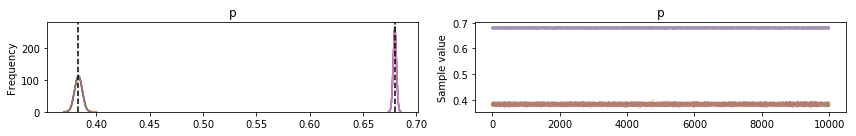

In [5]:
def takeFirst(x):
    return x[:,0]
pls = pm.traceplot(model.trace, varnames=['p'], lines = sample_u)
                   #priors = [pm.Beta.dist(alpha_post[0], beta_post[0]), pm.Beta.dist(alpha_post[1], beta_post[1])])
pls[0,0].axvline(x=tumorAv, color='black',ls='--')
pls[0,0].axvline(x=freeAv, color='black',ls='--')

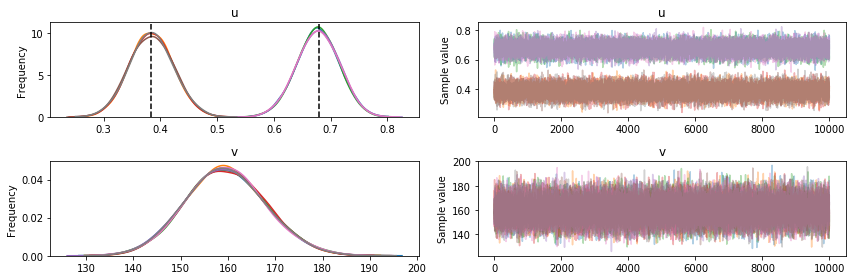

In [6]:
pls = pm.traceplot(model.trace, varnames=['u', 'v'])
pls[0,0].axvline(x=tumorAv, color='black',ls='--')
pls[0,0].axvline(x=freeAv, color='black',ls='--')

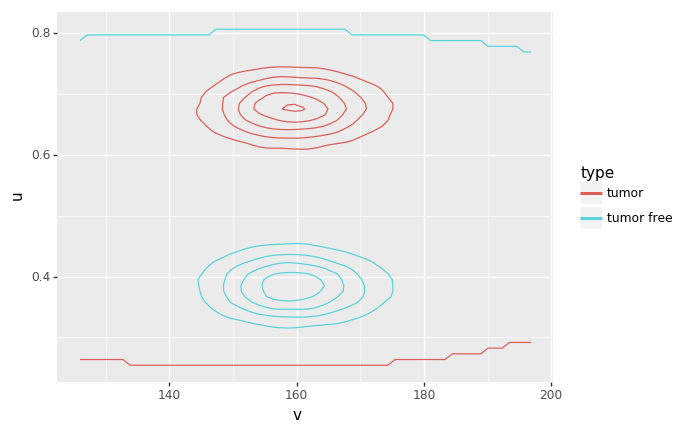

In [7]:
tumor = pd.DataFrame({'v':model.trace['v'][:,0], 'u':model.trace['u'][:,0], 'type':'tumor'})
free = pd.DataFrame({'v':model.trace['v'][:,1], 'u':model.trace['u'][:,1], 'type':'tumor free'})
_ = (ggplot(aes('v', 'u', color = 'type'), data = tumor.append(free)) + stat_density_2d()).draw()

In [8]:
v_post = model.trace['v'].mean(axis=0)
u_post = model.trace['u'].mean(axis=0)
alpha_post = v_post * u_post
beta_post = v_post * (1 - u_post)

/homes/olymp/dominik.otto/Envs/noteEnv2/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


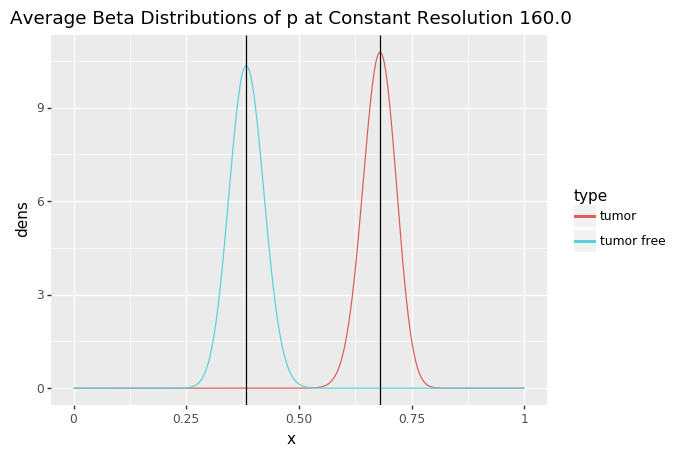

In [9]:
xs = np.linspace(0, 1, 1e3)
tumor = pd.DataFrame({'x':xs, 'dens':beta.pdf(xs, alpha_post[0], beta_post[0]), 'type':'tumor'})
free = pd.DataFrame({'x':xs, 'dens':beta.pdf(xs, alpha_post[1], beta_post[1]), 'type':'tumor free'})
_ = (ggplot(aes('x', 'dens', color = 'type'), data = tumor.append(free)) + geom_line() +
     ggtitle('Average Beta Distributions of p at Constant Resolution ' + str(v_post.mean().round())) +
     geom_vline(xintercept=tumorAv) + geom_vline(xintercept=freeAv)).draw()

/homes/olymp/dominik.otto/Envs/noteEnv2/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


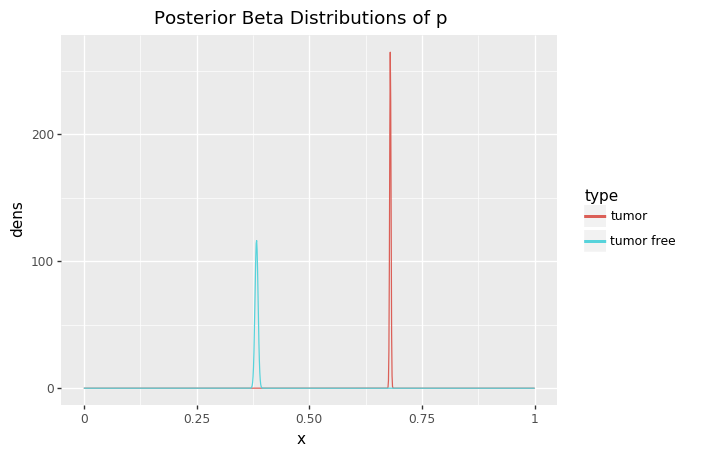

In [29]:
xs = np.linspace(0, 1, 1e3)
tumor = pd.DataFrame({'x':xs, 'dens':beta.pdf(xs, alpha_tumor, beta_tumor), 'type':'tumor'})
free = pd.DataFrame({'x':xs, 'dens':beta.pdf(xs, alpha_free, beta_free), 'type':'tumor free'})
_ = (ggplot(aes('x', 'dens', color = 'type'), data = tumor.append(free)) + geom_line() +
     ggtitle('Posterior Beta Distributions of p')).draw()

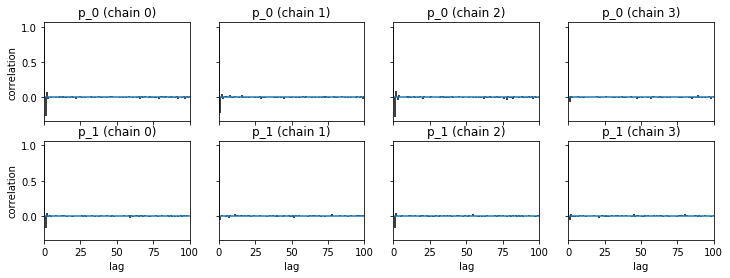

In [12]:
_ = pm.autocorrplot(model.trace, varnames=['p'])

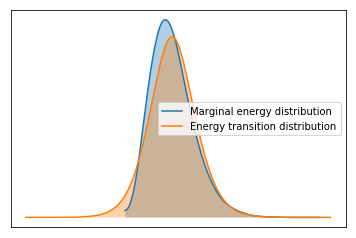

In [11]:
pm.energyplot(model.trace)